# Lattice FFT Package Demo

This notebook demonstrates the modular `lattice_fft` package for crystal lattice simulation and reciprocal space analysis.

## Package Structure

The package is organized into focused modules:
- `lattice.py`: Lattice generation and defect introduction
- `atoms.py`: Atomic rendering with Gaussian distributions
- `fft_utils.py`: FFT computation and reciprocal space utilities
- `visualization.py`: Plotting functions for analysis

## Installation

To use the package, ensure it's in your Python path or install it:
```bash
pip install -e .
```

In [8]:
# Import the lattice_fft package
import numpy as np
import matplotlib.pyplot as plt

# Import specific modules
from lattice_fft import (
    make_lattice_positions,
    introduce_defects,
    add_jitter,
    render_lattice,
    compute_fft,
    plot_2x2_comparison,
    plot_lattice,
    plot_fft
)

print("lattice_fft package imported successfully!")

lattice_fft package imported successfully!


## Example 1: Basic Square Lattice

Generate a perfect square lattice and compute its FFT.

Generated 2304 atomic positions


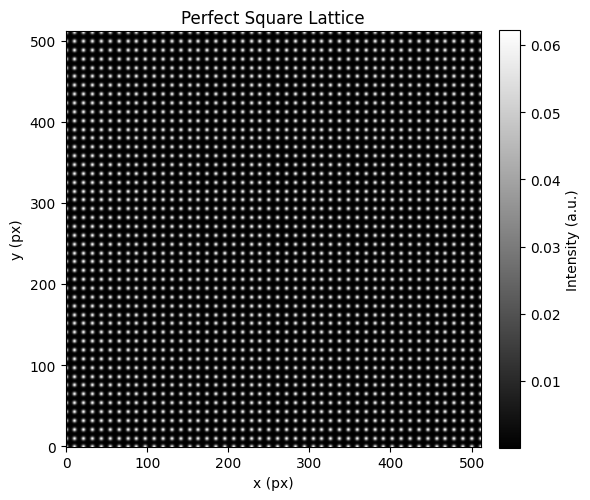

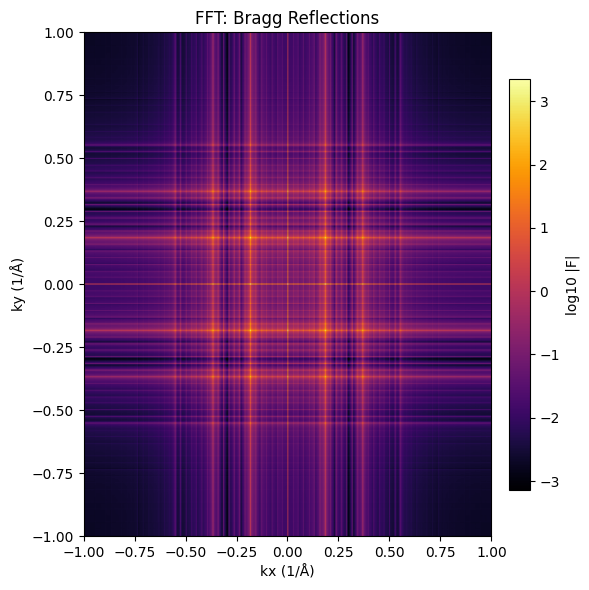

In [9]:
# Simulation parameters
ny, nx = 512, 512          # Image dimensions
px_size_A = 0.5            # Angstrom per pixel
a_A = 5.43                 # Lattice constant (silicon-like)
atom_sigma_A = 0.8         # Atomic width

# Convert to pixels
period_px = a_A / px_size_A
atom_sigma_px = atom_sigma_A / px_size_A

# Generate square lattice
positions = make_lattice_positions(ny, nx, period_px, basis='square')
print(f"Generated {len(positions)} atomic positions")

# Render the lattice
lattice_img = render_lattice(ny, nx, positions, atom_sigma_px)

# Compute FFT
fft_img = compute_fft(lattice_img, log_scale=True)

# Visualize
plot_lattice(lattice_img, title="Perfect Square Lattice")
plot_fft(fft_img, px_size_A, title="FFT: Bragg Reflections", klim=1.0)
plt.show()

## Example 2: Hexagonal Lattice

Generate a hexagonal (close-packed) lattice structure.

Generated 2613 atomic positions (hexagonal)


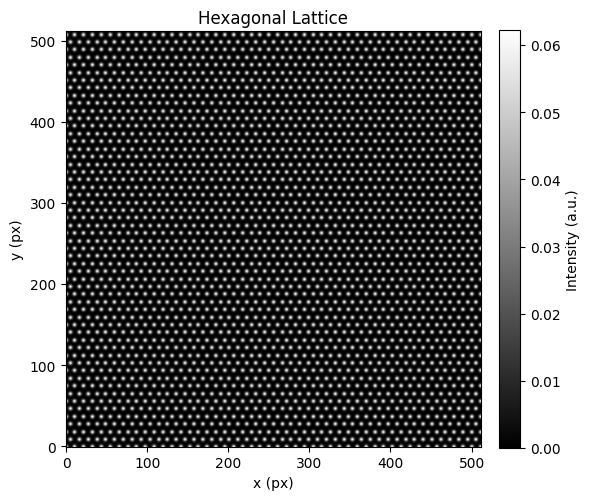

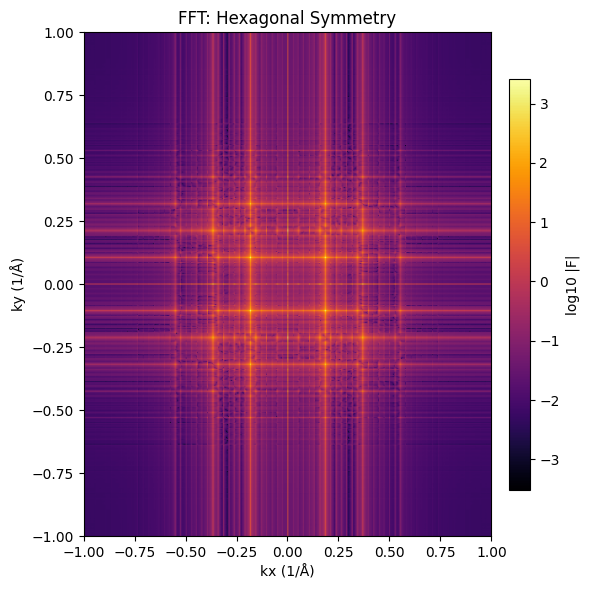

In [10]:
# Generate hexagonal lattice
positions_hex = make_lattice_positions(ny, nx, period_px, basis='hex')
print(f"Generated {len(positions_hex)} atomic positions (hexagonal)")

# Render and compute FFT
lattice_hex = render_lattice(ny, nx, positions_hex, atom_sigma_px)
fft_hex = compute_fft(lattice_hex, log_scale=True)

# Visualize
plot_lattice(lattice_hex, title="Hexagonal Lattice")
plot_fft(fft_hex, px_size_A, title="FFT: Hexagonal Symmetry", klim=1.0)
plt.show()

## Example 3: Introducing Defects

Compare perfect vs defected lattices using the 2x2 comparison plot.

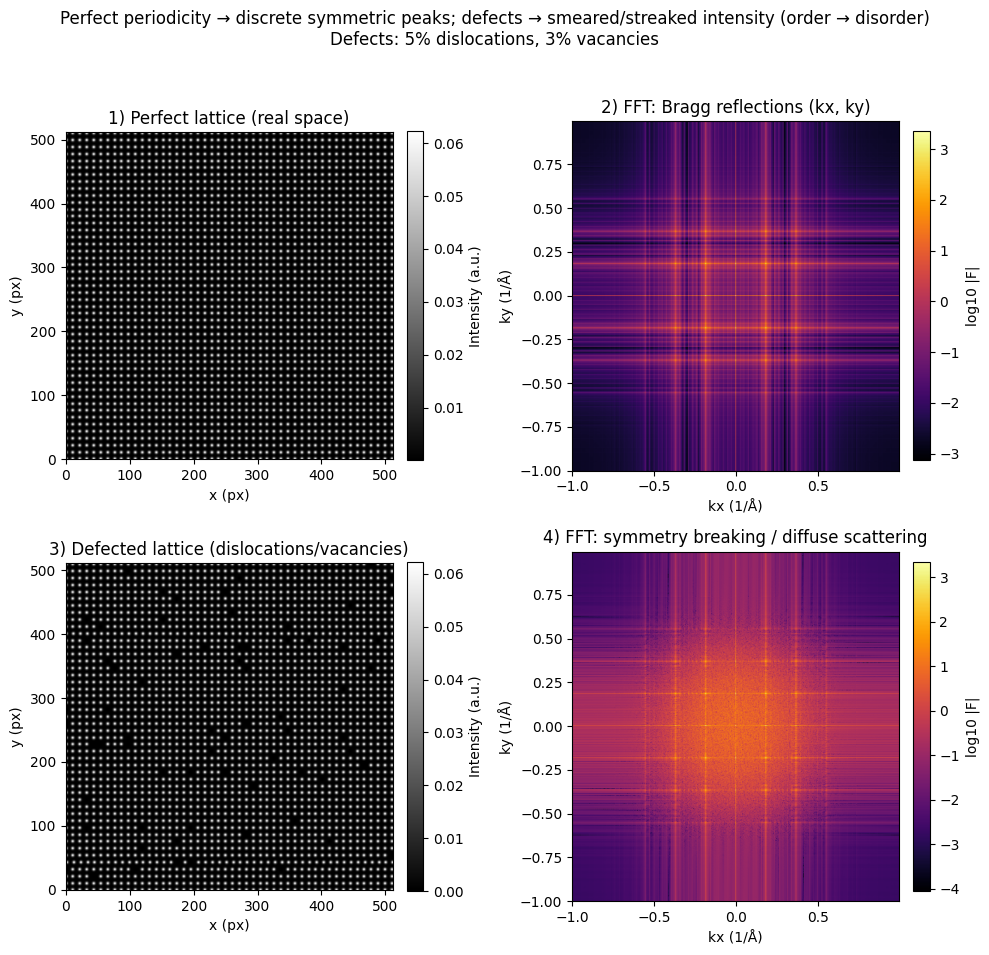

Perfect: 2304 atoms
Defected: 2235 atoms


In [11]:
# Create random number generator for reproducibility
rng = np.random.default_rng(42)

# Perfect lattice
positions_perfect = make_lattice_positions(ny, nx, period_px, basis='square')
img_perfect = render_lattice(ny, nx, positions_perfect, atom_sigma_px)
fft_perfect = compute_fft(img_perfect)

# Defected lattice
positions_defect = introduce_defects(
    positions_perfect, 
    ny, nx,
    defect_fraction=0.05,      # 5% rows with dislocations
    max_row_shift_px=2.0,      # ±2 pixel shifts
    remove_fraction=0.03,      # 3% vacancy rate
    rng=rng
)
img_defect = render_lattice(ny, nx, positions_defect, atom_sigma_px)
fft_defect = compute_fft(img_defect)

# Compare side-by-side
plot_2x2_comparison(
    img_perfect, fft_perfect,
    img_defect, fft_defect,
    px_size_A,
    title_suffix="Defects: 5% dislocations, 3% vacancies"
)
plt.show()

print(f"Perfect: {len(positions_perfect)} atoms")
print(f"Defected: {len(positions_defect)} atoms")

## Example 4: Thermal Disorder (Jitter)

Simulate thermal motion by adding random Gaussian displacements.

In [ ]:
# Generate lattice with increasing jitter
jitter_levels = [0.0, 0.5, 1.0, 2.0]  # in pixels

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, sigma_jitter in enumerate(jitter_levels):
    # Apply jitter
    if sigma_jitter > 0:
        pos_jitter = add_jitter(positions_perfect, sigma_jitter, rng=rng)
    else:
        pos_jitter = positions_perfect
    
    # Render and FFT
    img_jitter = render_lattice(ny, nx, pos_jitter, atom_sigma_px)
    fft_jitter = compute_fft(img_jitter)
    
    # Plot real space
    axes[0, i].imshow(img_jitter, cmap='gray', origin='lower')
    axes[0, i].set_title(f'Jitter σ = {sigma_jitter:.1f} px')
    axes[0, i].set_xlabel('x (px)')
    if i == 0:
        axes[0, i].set_ylabel('Real space')
    
    # Plot FFT
    from lattice_fft.fft_utils import reciprocal_axes
    kx, ky = reciprocal_axes(ny, nx, px_size_A)
    extent = [kx[0], kx[-1], ky[0], ky[-1]]
    
    axes[1, i].imshow(fft_jitter, cmap='inferno', origin='lower', 
                     extent=extent, aspect='auto')
    axes[1, i].set_xlim(-1.0, 1.0)
    axes[1, i].set_ylim(-1.0, 1.0)
    axes[1, i].set_xlabel('kx (1/Å)')
    if i == 0:
        axes[1, i].set_ylabel('FFT (log)')

fig.suptitle('Effect of Thermal Jitter on Bragg Peak Sharpness', fontsize=14)
plt.tight_layout()
plt.show()

print("Notice: Increasing jitter → peak broadening (Debye-Waller effect)")

## Example 5: Unit Cell Comparison

Demonstrate the inverse relationship: smaller d → wider 1/d spacing.

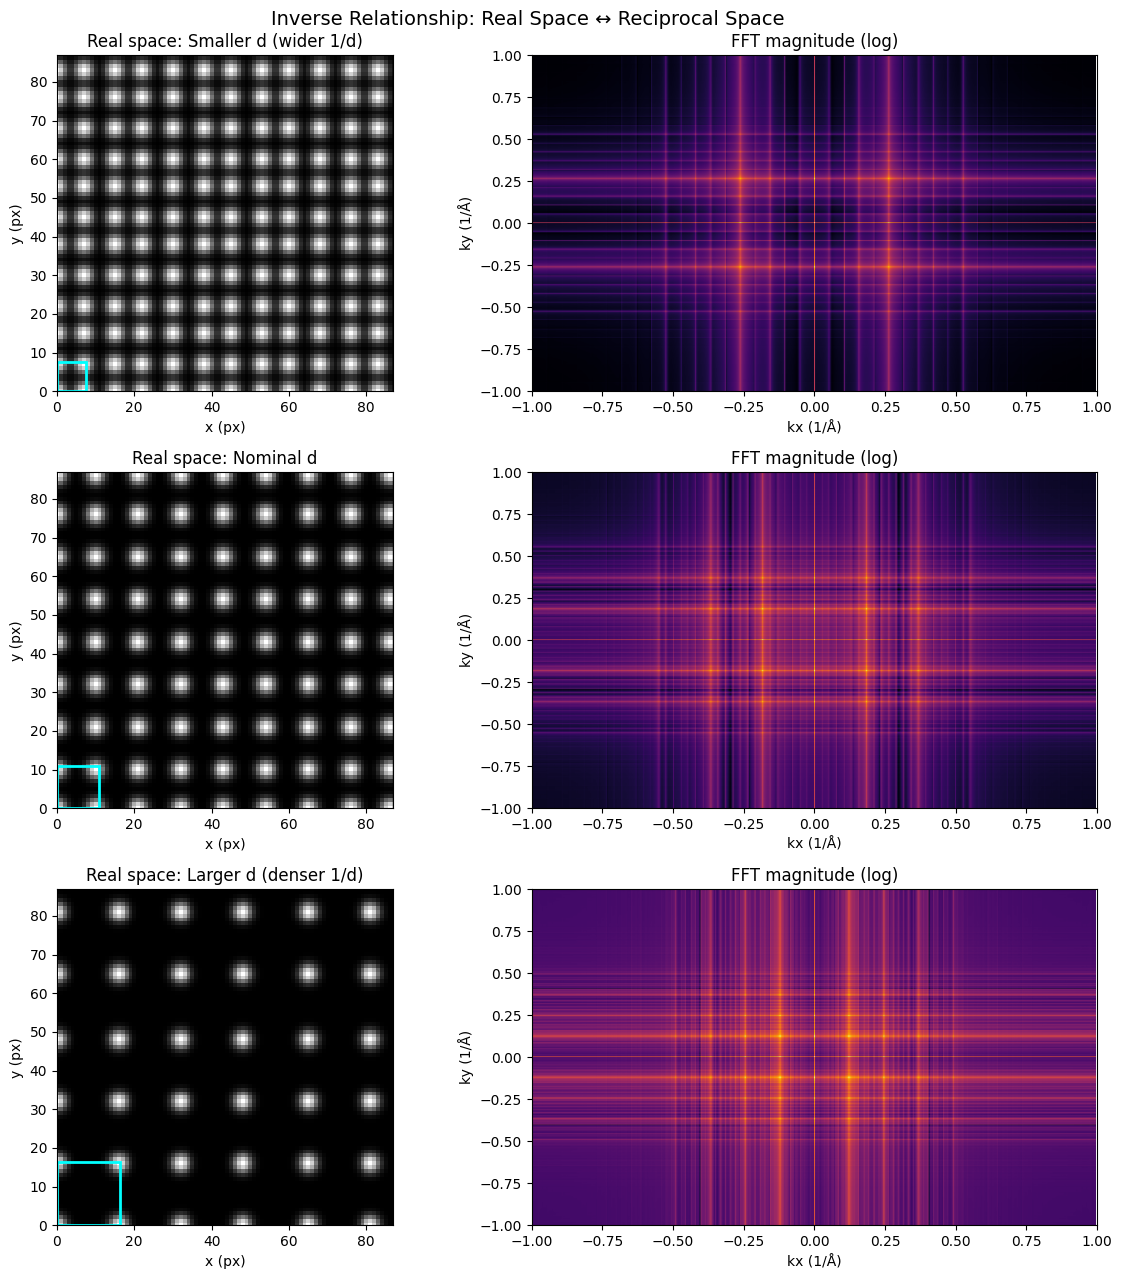

Key observation: Peak separation in FFT is inversely proportional to lattice constant


In [ ]:
# Compare different lattice constants
factors = [0.7, 1.0, 1.5]
labels = ['Smaller d (wider 1/d)', 'Nominal d', 'Larger d (denser 1/d)']

fig, axes = plt.subplots(3, 2, figsize=(12, 13))

for i, (factor, label) in enumerate(zip(factors, labels)):
    # Generate lattice with scaled period
    scaled_period_px = period_px * factor
    pos = make_lattice_positions(ny, nx, scaled_period_px, basis='square')
    
    # Render and FFT
    img = render_lattice(ny, nx, pos, atom_sigma_px)
    fft_img = compute_fft(img)
    
    # Real space (zoomed to show unit cells)
    view_px = 8 * period_px
    axes[i, 0].imshow(img, cmap='gray', origin='lower')
    axes[i, 0].set_xlim(0, view_px)
    axes[i, 0].set_ylim(0, view_px)
    axes[i, 0].set_title(f'Real space: {label}')
    axes[i, 0].set_xlabel('x (px)')
    axes[i, 0].set_ylabel('y (px)')
    
    # Add unit cell box
    from matplotlib.patches import Rectangle
    rect = Rectangle((0, 0), scaled_period_px, scaled_period_px,
                    linewidth=2, edgecolor='cyan', facecolor='none')
    axes[i, 0].add_patch(rect)
    
    # FFT (standardized axes)
    kx, ky = reciprocal_axes(ny, nx, px_size_A)
    extent = [kx[0], kx[-1], ky[0], ky[-1]]
    
    axes[i, 1].imshow(fft_img, cmap='inferno', origin='lower',
                     extent=extent, aspect='auto')
    axes[i, 1].set_xlim(-1.0, 1.0)
    axes[i, 1].set_ylim(-1.0, 1.0)
    axes[i, 1].set_title('FFT magnitude (log)')
    axes[i, 1].set_xlabel('kx (1/Å)')
    axes[i, 1].set_ylabel('ky (1/Å)')

fig.suptitle('Inverse Relationship: Real Space ↔ Reciprocal Space', fontsize=14)
plt.tight_layout()
plt.show()

print("Key observation: Peak separation in FFT is inversely proportional to lattice constant")

## Example 6: Custom Analysis Pipeline

Build a custom analysis using the modular functions.

In [ ]:
def analyze_lattice_quality(positions, ny, nx, sigma_px, px_size_A, title=""):
    """
    Custom function to analyze lattice quality metrics.
    """
    # Render
    img = render_lattice(ny, nx, positions, sigma_px)
    
    # Compute FFT
    from lattice_fft.fft_utils import get_fft_magnitude
    fft_mag = get_fft_magnitude(img, log_scale=False)
    
    # Calculate metrics
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    peak_fft = np.max(fft_mag)
    
    # Central region analysis (DC component)
    cy, cx = ny // 2, nx // 2
    dc_value = fft_mag[cy, cx]
    
    print(f"{title}")
    print(f"  Atoms: {len(positions)}")
    print(f"  Mean intensity: {mean_intensity:.4f}")
    print(f"  Std intensity: {std_intensity:.4f}")
    print(f"  Peak FFT magnitude: {peak_fft:.2e}")
    print(f"  DC component: {dc_value:.2e}")
    print()
    
    return img, fft_mag

# Analyze different cases
rng = np.random.default_rng(123)

# Perfect lattice
pos1 = make_lattice_positions(ny, nx, period_px, basis='square')
img1, fft1 = analyze_lattice_quality(pos1, ny, nx, atom_sigma_px, px_size_A, 
                                     "Perfect Lattice:")

# With defects
pos2 = introduce_defects(pos1, ny, nx, defect_fraction=0.1, 
                        remove_fraction=0.05, rng=rng)
img2, fft2 = analyze_lattice_quality(pos2, ny, nx, atom_sigma_px, px_size_A,
                                     "Defected Lattice:")

# With jitter
pos3 = add_jitter(pos1, sigma_jitter_px=1.5, rng=rng)
img3, fft3 = analyze_lattice_quality(pos3, ny, nx, atom_sigma_px, px_size_A,
                                     "Jittered Lattice:")

Perfect Lattice:
  Atoms: 2304
  Mean intensity: 0.0086
  Std intensity: 0.0140
  Peak FFT magnitude: 2.25e+03
  DC component: 2.25e+03

Defected Lattice:
  Atoms: 2189
  Mean intensity: 0.0082
  Std intensity: 0.0138
  Peak FFT magnitude: 2.14e+03
  DC component: 2.14e+03

Jittered Lattice:
  Atoms: 2304
  Mean intensity: 0.0085
  Std intensity: 0.0139
  Peak FFT magnitude: 2.23e+03
  DC component: 2.23e+03



## Summary

This notebook demonstrated the `lattice_fft` package capabilities:

1. **Modular Design**: Clean separation of concerns (lattice, atoms, FFT, visualization)
2. **Flexible Lattice Generation**: Square and hexagonal symmetries
3. **Defect Modeling**: Dislocations, vacancies, and thermal disorder
4. **Reciprocal Space Analysis**: FFT computation with physical units
5. **Rich Visualization**: Multiple plot types for comprehensive analysis
6. **Extensibility**: Easy to build custom analysis pipelines

## Next Steps

- Extend to 3D lattices
- Add structure factor calculations
- Implement peak detection and indexing
- Compare with experimental diffraction data
- Add strain field analysis